In [1]:
import re
import glob
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
import scipy.stats as stats

In [2]:
def fasta_to_dataframe(seq):
    fasta_df = pd.read_csv(seq, sep='>', lineterminator='>', header=None)
    fasta_df[['tid','seq']]=fasta_df[0].str.split('\n', 1, expand=True)
    fasta_df['tid'] = fasta_df['tid']
    fasta_df['seq'] = fasta_df['seq'].replace('\n','', regex=True)
    fasta_df.drop(0, axis=1, inplace=True)
    fasta_df = fasta_df[fasta_df.seq != '']
    final_df = fasta_df.dropna()
    return final_df


def site_histories(df, sites, history, posterior, columns):
    """
    Parsing Malin's site histories output
    265 species
    history = loss, posterior = 0.9, columns = 530:795
    history = gain, posterior = 0.9 columns = 1051:1316
    """
    cols = columns.split(':')
    start = int(cols[0])
    end = int(cols[1])
    ls = df.iloc[:,start:end]
    for i in ls.columns:
        ls[i] = ls[i].astype(float)

    l = []
    for i in ls.columns:
        l.append(ls[ls[i]>float(posterior)])
    l = pd.concat(l)
    l = l.reset_index().rename(columns={'index':'site'})
    l = pd.merge(sites, l, on='site').drop_duplicates()

    ll = []
    for i in ls.columns:
        filt = l[['alignment','alipos',i]]
        filt = filt[filt[i]>float(posterior)]
        filt = pd.DataFrame(filt.groupby('alignment').alipos.agg(list)).reset_index()
        filt.columns = ['ortho','alipos']
        site = '-' + history
        filt['species'] = i.replace(site,'')
        ll.append(filt)
    ll = pd.concat(ll).reset_index(drop=True)
    ll['history'] = history
    return ll


def residue_position(seq):
    residues = list(re.finditer('[A-Z]+', seq))
    residue_pos = []
    for k,v in enumerate(residues):
        residue_pos.extend(list(range(v.start()*3, v.end()*3)))
    return residue_pos


def find_pos(i, j):
    if i[0]!=0:
        try:
            pos = i.index(j)
        except ValueError:
            pos = 'NaN'
    elif i[0]==0:
        pos = 0
    else:
        pos = 'NaN'
    return pos


def get_exons(pos):
    exons = []
    for i in range(len(pos)):
        if i < len(pos)-1:
            if pos[i] < pos[i+1]:
                exons.append([pos[i], pos[i+1]])
            elif pos[i] > pos[i+1]:
                print('Wrong CDS end position! ' + 
                      str(pos[i]) + ',' + str(pos[i+1]))
    return exons

In [3]:
# get intron positions
f = glob.glob('../intron_alignment_files/*.faaa')
df = []
for i in f:
    df.append(fasta_to_dataframe(i))

df = pd.concat(df).reset_index(drop=True)
df[['tid','ipos']] = df.tid.str.split(r'{i|i}',expand=True).drop([2],axis=1)
df[['species','tid','ortho']] = df['tid'].str.split(expand=True)[[1,0,3]]
df['species'] = df.species.str.replace('/organism=','')
df['ipos'] = df.ipos.str.replace(r'\s+','')\
.apply(lambda x: 0 if len(x)==0 else x)\
.str.split(',')\
.fillna({i: [0] for i in df.index})\
.apply(lambda x: [int(i) for i in x])

In [4]:
# get intron site histories
sites = pd.read_csv('../malin_input_files/intron_table_40129_48.txt',sep='\t', skiprows=266)[['site','alignment','alipos']]
# site_histories_40129_2L_1G.txt.gz is available at https://doi.org/10.5281/zenodo.4273072
h = pd.read_csv('site_histories_40129_2L_1G.txt.gz',sep='\t', skiprows=3)
stats = h[['site','prob0','prob1','present','ambiguous','lost','gained']]
h['prob0'] = h.prob0.astype(float)
h['prob1'] = h.prob1.astype(float)
sites = pd.merge(sites,stats,on='site')

# get intron site histories
ll = site_histories(h, sites, 'loss', '0.99', '530:795')
gg = site_histories(h, sites, 'gain', '0.99', '1051:1316')
pp = site_histories(h, sites, 'present', '0.99', '8:273')

In [5]:
h = pd.concat([gg,ll,pp]).reset_index(drop=True)
dt = pd.merge(h,df,on=['species','ortho'])

# get all nt positions in alignment
dt['pos'] = dt.seq.apply(lambda x: residue_position(x))

# map alipos (ipos in alignment) to nt positions in alignment
dt = dt.explode('alipos').reset_index(drop=True)
dt['evolved_ipos'] = dt[['alipos','pos']].values.tolist()
dt['evolved_ipos'] = dt.evolved_ipos.apply(lambda x: find_pos(x[1],x[0]))

# compare annotated length and protein sequence length
# a = pd.read_csv('annotations.total.txt', sep='\t', comment='#', header=None, usecols=[1,5])
# a.columns = ['tid','annotated_length']
# a['annotated_length'] = (a.annotated_length*3).astype(int)
# dt = pd.merge(dt, a, on='tid')
# w = dt[~(dt.seq_length==dt.annotated_length) & ~(dt.seq_length-dt.annotated_length==3) & ~(dt.seq_length-dt.annotated_length==-3)]
# (w.seq_length-w.annotated_length).sort_values(ascending=False)
# dt[dt.seq_length-dt.annotated_length==-3].shape,dt[dt.seq_length-dt.annotated_length==3].shape

# get nth intron
dt['nth_intron'] = dt.evolved_ipos.apply(lambda x: [x]) + dt.ipos
dt['nth_intron'] = dt.nth_intron.apply(lambda x: np.unique(x).tolist())
dt['nth_intron'] = dt[['evolved_ipos','nth_intron']].values.tolist()
dt['nth_intron'] = dt.nth_intron.apply(lambda x: find_pos(x[1],x[0]) + 1)

# get intron counts
dt['intron_counts'] = dt.ipos.apply(lambda x: len(x) if x[0]!=0 else 0)

# get exon positions
dt['seq_length'] = dt.seq.apply(lambda x: len(x.replace('-',''))*3)
dt['epos'] = (pd.Series([0] * len(dt)).apply(lambda x: [x]) + 
              dt.seq_length.apply(lambda x: [x]) +
              dt.evolved_ipos.apply(lambda x: [x]) +
              dt.ipos).apply(lambda x: np.unique(x).tolist())
dt.drop(['alipos','seq','pos'], axis=1, inplace=True)
dt = dt[(dt.epos.apply(lambda x: len(x))!=2) & (dt.evolved_ipos!='NaN')]

# get all exons
dt['exons'] = dt.epos.apply(lambda x: get_exons(x))

# get intron loss/gain exons
dt['evolved_exons'] = dt[['nth_intron','epos']].values.tolist()
dt['evolved_exons'] = dt.evolved_exons.apply(lambda x: [x[1][x[0]-1], x[1][x[0]], x[1][x[0]+1]])
dt['evolved_ipos'] = dt.evolved_ipos.astype(int)
dt['seq_length'] = dt.seq_length.astype(int)
dt['check_ipos'] = dt[['ipos','evolved_ipos']].values.tolist()
dt['check_ipos'] = dt.check_ipos.apply(lambda x: [i for i in x[0] if i==x[1]])
dtl = dt[dt.history=='loss']
dtgp = dt[dt.astype(str)['check_ipos'] != '[]']
dt = pd.concat([dtl,dtgp])
dt = dt[(dt.evolved_ipos!=0) & (dt.evolved_ipos!=dt.seq_length)]
dt['check_ends'] = dt[['ipos','seq_length']].values.tolist()
dt = dt[(dt.check_ends.apply(lambda x: x[0][0]!=0)) & 
            (dt.check_ends.apply(lambda x: x[0][-1]!=x[1]))]
dt.to_pickle('evolved_exons.pkl')

In [6]:
# dt = pd.read_pickle('evolved_exons.pkl')
dt = dt[(~dt.tid.str.contains('9606')) & (~dt.tid.str.contains('691883'))]

In [7]:
# get exon present
e = dt[dt.history=='present'][['tid','evolved_exons']]
e['Length (bp)'] = e.evolved_exons.apply(lambda x: [x[1]-x[0], x[2]-x[1]])
e['Exons'] = 'present'
e = e.explode('Length (bp)').drop_duplicates(['tid','Length (bp)'])[['tid','Length (bp)','Exons']]

In [8]:
# get representative exons from intron loss events
ele = pd.DataFrame(dt[dt.history=='loss'].groupby('tid').evolved_exons.agg(list)).reset_index()
ele['taxid'] = ele.tid.str.split('|').apply(lambda x: x[0])
ele['fused_exons'] = ele.evolved_exons.apply(lambda x: np.unique(list(itertools.chain.from_iterable(x))).tolist())
ele['fused_counts'] = ele.fused_exons.apply(lambda x: len(x))

# get 2-into-1 and 3-into-1 exons
p = ele[(ele.fused_counts==3) | (ele.fused_counts==4)].reset_index(drop=True)
p['length'] = p.fused_exons.apply(lambda x: x[-1] - x[0])
p = p[['tid','length','fused_counts']]

# get some other 2-into-1 exons
f = ele[(ele.fused_counts==5) & 
        (ele.evolved_exons.apply(lambda x: len(x)==2))].reset_index(drop=True)
f['length'] = f.evolved_exons.apply(lambda x: [x[0][-1] - x[0][0], x[1][-1] - x[1][0]])
f = f[['tid','length','fused_counts']].explode('length')

p = pd.concat([p,f])
p['fused_counts'] = p.fused_counts.astype(str).replace('3','2-into-1')\
.replace('4','3-into-1').replace('5','2-into-1')
p.columns = ['tid','Length (bp)','Exons']
p.drop_duplicates(['tid','Length (bp)'], inplace=True)

In [9]:
# get representative exons from intron gain events
# please download annotations.total.txt.gz from https://doi.org/10.5281/zenodo.4273072
anno = pd.read_csv('annotations.total.txt.gz', sep='\t', comment='#', header=None, usecols=[0,2,4,11,12])
anno.columns = ['chr','tid','strand','exon_start','exon_end']
anno = pd.merge(dt, anno, on='tid')
anno['exon_start'] = anno.exon_start.str.split(',')
anno['exon_end'] = anno.exon_end.str.split(',')
anno['intron_range'] = anno[['strand','nth_intron','exon_start','exon_end']].values.tolist()

anno['evolved_ipos'] = anno.evolved_ipos.astype(int)
anno['seq_length'] = anno.seq_length.astype(int)
anno['check_ipos'] = anno[['ipos','evolved_ipos']].values.tolist()
anno['check_ipos'] = anno.check_ipos.apply(lambda x: [i for i in x[0] if i==x[1]])
al = anno[anno.history=='loss']
agp = anno[anno.astype(str)['check_ipos'] != '[]']
anno = pd.concat([al,agp])
anno = anno[(anno.evolved_ipos!=0) & (anno.evolved_ipos!=anno.seq_length)]
anno['check_ends'] = anno[['ipos','seq_length']].values.tolist()
anno = anno[(anno.check_ends.apply(lambda x: x[0][0]!=0)) & 
            (anno.check_ends.apply(lambda x: x[0][-1]!=x[1]))]

a = anno[anno.history=='gain'].reset_index(drop=True)
a['intron_range'] = a.intron_range.apply(lambda x: 
                                         [x[3][x[1]-1], x[2][x[1]]] 
                                         if x[0]=='+' else 
                                         [x[3][len(x[2])-x[1]-1], x[2][len(x[2])-x[1]]])

a['intron_start'] = a.intron_range.apply(lambda x: x[0])
a['intron_end'] = a.intron_range.apply(lambda x: x[1])
a['intron'] = a.tid.str.split('|').apply(lambda x: x[0]) \
+ '|' + a.chr + ':' + a.intron_start + '-' + a.intron_end + '(' + a.strand + ')'
# a.to_pickle('gained_introns.pkl')

In [10]:
sus = pd.read_csv('../gained_introns/suspecious_introns.txt', sep='\t', header=None)
sus.columns = ['intron']
a = sus.join(a.set_index('intron'), on='intron', how='outer').reset_index()
a = a[a['index'].isna()].drop('index', axis=1)

In [11]:
# a = pd.read_pickle('gained_introns.pkl')
se = pd.DataFrame(a[a.history=='gain'].groupby('tid').evolved_exons.agg(list)).reset_index()
se['taxid'] = se.tid.str.split('|').apply(lambda x: x[0])
se['split_exons'] = se.evolved_exons.apply(lambda x: np.unique(list(itertools.chain.from_iterable(x))).tolist())
se['split_counts'] = se.split_exons.apply(lambda x: len(x))

# get 1-into-2 and 1-into-3 exons
q = se[(se.split_counts==3) | (se.split_counts==4)].reset_index(drop=True)
q = q[['tid','split_exons','split_counts']]

In [12]:
# get some other 1-into-2 exons
s = se[(se.split_counts==5) & 
       (se.evolved_exons.apply(lambda x: len(x)==2))].reset_index(drop=True)
s = s.explode('evolved_exons')[['tid','evolved_exons']]
s['split_counts'] = 3
s.columns = ['tid','split_exons','split_counts']

# get exon lengths
q = pd.concat([q,s])
q['length'] = q.split_exons.apply(lambda x:
                                  [x[2]-x[1], x[1]-x[0]] if len(x)==3 else 
                                  [x[3]-x[2], x[2]-x[1], x[1]-x[0]])
q = q.explode('length')[['tid','length','split_counts']]

q['split_counts'] = q.split_counts.astype(str).replace('3','1-into-2').replace('4','1-into-3')
q.columns = ['tid','Length (bp)','Exons']
q.drop_duplicates(['tid','Length (bp)'], inplace=True)

In [13]:
# median lengths of different exon classes
e = pd.concat([p,q,e]).drop_duplicates(['tid','Length (bp)'])
e = e[e.Exons=='present']
dd = pd.concat([p,q,e])
dd['Length (bp)'] = dd['Length (bp)'].astype(int)

In [14]:
# summary of representative dataset
summary = dd.groupby('Exons').median().reset_index()
summary.columns = ['Exons','Median length (bp)']
total = pd.DataFrame(dd.Exons.value_counts()).reset_index()
total.columns = ['Exons','Counts']
pd.merge(summary,total,on='Exons')

,Exons,Median length (bp),Counts
0,1-into-2,229.0,4092
1,1-into-3,210.5,408
2,2-into-1,462.0,11864
3,3-into-1,1044.5,1254
4,present,173.0,372618


In [15]:
1044.5/173

6.03757225433526

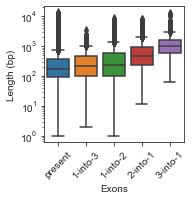

In [16]:
plt.figure(figsize=(2.5,2.5))
sns.set_style("ticks")
g = sns.boxplot(x='Exons', y='Length (bp)', data=dd,
                order=['present','1-into-3','1-into-2','2-into-1','3-into-1']) #showfliers = False)
# g = sns.stripplot('fused_counts', 'length', data=p, 
#                   jitter=0.4, size=4, alpha=0.01, palette='tab10', linewidth=1)
g.set_yscale('log')
g.set_xticklabels(g.get_xticklabels(),rotation=45)
# plt.savefig('evolved_exons.pdf', bbox_inches='tight')
plt.savefig('evolved_exons.png', dpi=600, bbox_inches='tight')

In [17]:
dd['log_length'] = np.log10(dd['Length (bp)'])

In [18]:
pg.pairwise_ttests(dv='log_length', between='Exons', tail='one-sided', padjust='bonf', data=dd)

/home/chunlim/anaconda3/lib/python3.7/site-packages/pingouin/bayesian.py:152: RuntimeWarning: divide by zero encountered in double_scalars
  bf10 = 1 / ((1 + t**2 / df)**(-(df + 1) / 2) / integr)


,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,hedges
0,Exons,2-into-1,3-into-1,False,True,-31.247878,1694.000457,one-sided,6.022856e-170,6.022856e-169,bonf,8.224e+202,-0.776824
1,Exons,2-into-1,1-into-2,False,True,31.361326,5958.437969,one-sided,2.917357e-200,2.917357e-199,bonf,4.522e+205,0.635787
2,Exons,2-into-1,1-into-3,False,True,13.925474,426.904630,one-sided,6.617042e-37,6.617042e-36,bonf,3.485e+40,0.826382
3,Exons,2-into-1,present,False,True,102.288538,12777.244768,one-sided,0.000000e+00,0.000000e+00,bonf,inf,0.879707
4,Exons,3-into-1,1-into-2,False,True,48.145953,3295.669566,one-sided,0.000000e+00,0.000000e+00,bonf,inf,1.235180
5,Exons,3-into-1,1-into-3,False,True,25.230827,531.748638,one-sided,2.993314e-93,2.993314e-92,bonf,3.026e+115,1.746373
6,Exons,3-into-1,present,False,True,75.734420,1268.638207,one-sided,0.000000e+00,0.000000e+00,bonf,inf,1.579104
7,Exons,1-into-2,1-into-3,False,True,2.405805,502.299532,one-sided,8.248630e-03,8.248630e-02,bonf,2.041,0.119247
8,Exons,1-into-2,present,False,True,13.846362,4158.325391,one-sided,5.840735e-43,5.840735e-42,bonf,1.355e+40,0.251127
9,Exons,1-into-3,present,False,True,2.107281,407.744897,one-sided,1.785165e-02,1.785165e-01,bonf,1.003,0.114184


In [19]:
present = [len(dt[(dt.history=='present') & (dt.nth_intron==1)]),
           len(dt[(dt.history=='present') & (dt.nth_intron==2)]),
           len(dt[(dt.history=='present') & (dt.nth_intron==3)])]
loss = [len(dt[(dt.history=='loss') & (dt.nth_intron==1)]),
        len(dt[(dt.history=='loss') & (dt.nth_intron==2)]),
        len(dt[(dt.history=='loss') & (dt.nth_intron==3)])]
gain = [len(dt[(dt.history=='gain') & (dt.nth_intron==1)]),
        len(dt[(dt.history=='gain') & (dt.nth_intron==2)]),
        len(dt[(dt.history=='gain') & (dt.nth_intron==3)])]

In [20]:
np.array([present, loss]).T

array([[30851,  2040],
       [37296,  4721],
       [34019,  3994]])

In [21]:
obs = np.array([present, loss]).T
stats.chi2_contingency(obs)

(606.6614175705449,
 1.841395098328565e-132,
 2,
 array([[29758.34349678,  3132.65650322],
        [38015.15060972,  4001.84939028],
        [34392.5058935 ,  3620.4941065 ]]))

In [22]:
obs = np.array([gain, loss]).T
stats.chi2_contingency(obs)

(291.8337443613312,
 4.257038671220441e-64,
 2,
 array([[ 383.67634391, 2314.32365609],
        [ 759.95788802, 4584.04211198],
        [ 639.36576807, 3856.63423193]]))

In [23]:
obs = np.array([gain, present]).T
stats.chi2_contingency(obs)

(41.140342424509306,
 1.165435252676894e-09,
 2,
 array([[  540.46260185, 30968.53739815],
        [  650.41103811, 37268.58896189],
        [  592.12636004, 33928.87363996]]))

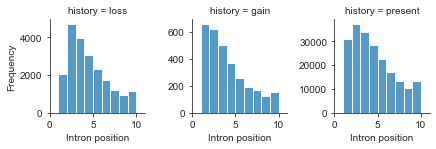

In [24]:
sns.set_style("ticks")
g = sns.FacetGrid(dt, col="history", sharey=False, height=2)
g.map_dataframe(sns.histplot, x="nth_intron", bins=range(0, 11, 1))
g.set(xlim=(0,11))
g.set_axis_labels("Intron position", "Frequency")
plt.savefig('nth_intron.pdf')

In [25]:
dt['nth_intron_rev'] = dt[['history','nth_intron','intron_counts']].values.tolist()
dt['nth_intron_rev'] = dt.nth_intron_rev.apply(lambda x: x[1]-x[2]-2 if x[0]=='loss' else x[1]-x[2]-1)
# loss = nth_intron-intron_counts-2
# gain = nth_intron-intron_counts-1
# gain = nth_intron-intron_counts-1

In [26]:
dt[dt.history=='loss'].sort_values('nth_intron_rev')

,ortho,species,history,tid,ipos,evolved_ipos,nth_intron,intron_counts,seq_length,epos,exons,evolved_exons,check_ipos,check_ends,nth_intron_rev
67319,fuNOG.ENOG410PH81.meta_raw,1344416,loss,1344416|KXS10872,"[71, 250, 335, 612, 848, 903, 990, 1107, 1180,...",3511,27,77,14886,"[0, 71, 250, 335, 612, 848, 903, 990, 1107, 11...","[[0, 71], [71, 250], [250, 335], [335, 612], [...","[3508, 3511, 3633]",[],"[[71, 250, 335, 612, 848, 903, 990, 1107, 1180...",-52
67320,fuNOG.ENOG410PH81.meta_raw,1344416,loss,1344416|KXS10872,"[71, 250, 335, 612, 848, 903, 990, 1107, 1180,...",3732,28,77,14886,"[0, 71, 250, 335, 612, 848, 903, 990, 1107, 11...","[[0, 71], [71, 250], [250, 335], [335, 612], [...","[3633, 3732, 3861]",[],"[[71, 250, 335, 612, 848, 903, 990, 1107, 1180...",-51
67321,fuNOG.ENOG410PH81.meta_raw,1344416,loss,1344416|KXS10872,"[71, 250, 335, 612, 848, 903, 990, 1107, 1180,...",3927,29,77,14886,"[0, 71, 250, 335, 612, 848, 903, 990, 1107, 11...","[[0, 71], [71, 250], [250, 335], [335, 612], [...","[3861, 3927, 4417]",[],"[[71, 250, 335, 612, 848, 903, 990, 1107, 1180...",-50
67322,fuNOG.ENOG410PH81.meta_raw,1344416,loss,1344416|KXS10872,"[71, 250, 335, 612, 848, 903, 990, 1107, 1180,...",4731,31,77,14886,"[0, 71, 250, 335, 612, 848, 903, 990, 1107, 11...","[[0, 71], [71, 250], [250, 335], [335, 612], [...","[4590, 4731, 5306]",[],"[[71, 250, 335, 612, 848, 903, 990, 1107, 1180...",-48
23642,fuNOG.ENOG410PFXY.meta_raw,914234,loss,914234|EMD41658,"[248, 491, 609, 961, 1356, 1399, 1440, 1641, 1...",1063,5,48,5988,"[0, 248, 491, 609, 961, 1063, 1356, 1399, 1440...","[[0, 248], [248, 491], [491, 609], [609, 961],...","[961, 1063, 1356]",[],"[[248, 491, 609, 961, 1356, 1399, 1440, 1641, ...",-45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13141,fuNOG.ENOG410PFTD.meta_raw,1328760,loss,1328760|KZF20084,[1793],2553,2,1,3303,"[0, 1793, 2553, 3303]","[[0, 1793], [1793, 2553], [2553, 3303]]","[1793, 2553, 3303]",[],"[[1793], 3303]",-1
54983,fuNOG.ENOG410QEE6.meta_raw,1280837,loss,1280837|166768,"[36, 376]",466,3,2,747,"[0, 36, 376, 466, 747]","[[0, 36], [36, 376], [376, 466], [466, 747]]","[376, 466, 747]",[],"[[36, 376], 747]",-1
54979,fuNOG.ENOG410PM2X.meta_raw,1280837,loss,1280837|143151,[169],399,2,1,2532,"[0, 169, 399, 2532]","[[0, 169], [169, 399], [399, 2532]]","[169, 399, 2532]",[],"[[169], 2532]",-1
24847,fuNOG.ENOG410PGTW.meta_raw,732165,loss,732165|EJF59309,"[43, 97, 276, 360, 1060, 1161, 1363]",1581,8,7,1662,"[0, 43, 97, 276, 360, 1060, 1161, 1363, 1581, ...","[[0, 43], [43, 97], [97, 276], [276, 360], [36...","[1363, 1581, 1662]",[],"[[43, 97, 276, 360, 1060, 1161, 1363], 1662]",-1


In [27]:
present = [len(dt[(dt.history=='present') & (dt.nth_intron_rev==-1)]),
           len(dt[(dt.history=='present') & (dt.nth_intron_rev==-2)]),
           len(dt[(dt.history=='present') & (dt.nth_intron_rev==-3)])]
loss = [len(dt[(dt.history=='loss') & (dt.nth_intron_rev==-1)]),
        len(dt[(dt.history=='loss') & (dt.nth_intron_rev==-2)]),
        len(dt[(dt.history=='loss') & (dt.nth_intron_rev==-3)])]
gain = [len(dt[(dt.history=='gain') & (dt.nth_intron_rev==-1)]),
        len(dt[(dt.history=='gain') & (dt.nth_intron_rev==-2)]),
        len(dt[(dt.history=='gain') & (dt.nth_intron_rev==-3)])]

In [28]:
present,loss,gain

([50797, 42281, 31941], [6757, 5057, 3078], [874, 612, 415])

In [29]:
obs = np.array([present, loss]).T
stats.chi2_contingency(obs)

(199.42787484443545,
 4.952074944818444e-44,
 2,
 array([[51428.00441709,  6125.99558291],
        [42299.38619551,  5038.61380449],
        [31291.6093874 ,  3727.3906126 ]]))

In [30]:
obs = np.array([gain, loss]).T
stats.chi2_contingency(obs)

(2.7829459546072495,
 0.24870869243306157,
 2,
 array([[ 863.84392306, 6767.15607694],
        [ 641.74173763, 5027.25826237],
        [ 395.41433931, 3097.58566069]]))

In [31]:
obs = np.array([gain, present]).T
stats.chi2_contingency(obs)

(24.75763272992037,
 4.206766048486004e-06,
 2,
 array([[  773.92507879, 50897.07492121],
        [  642.44873148, 42250.55126852],
        [  484.62618973, 31871.37381027]]))

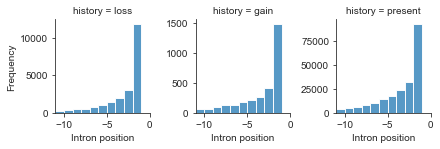

In [32]:
sns.set_style("ticks")
g = sns.FacetGrid(dt, col="history", sharey=False, height=2)
g.map_dataframe(sns.histplot, x="nth_intron_rev", bins=range(-11, 0, 1))
g.set(xlim=(-11,0))
g.set_axis_labels("Intron position", "Frequency")
plt.savefig('nth_intron_rev.pdf')

In [33]:
dt['evolved_ipos'] = dt.evolved_ipos.astype(int)
dt['dist_wrt_stop'] = dt.evolved_ipos - dt.seq_length
dt['norm_evolved_ipos'] = dt.evolved_ipos/dt.seq_length

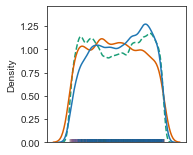

In [34]:
sns.set_style("ticks")
plt.figure(figsize=(2.5,2.5))
sns.kdeplot(x='norm_evolved_ipos', data=dt[dt.history=='present'], color='#1b9e77', 
            linestyle="--")
sns.kdeplot(x='norm_evolved_ipos', data=dt[dt.history=='gain'], color='#d95f02')
sns.kdeplot(x='norm_evolved_ipos', data=dt[dt.history=='loss'], color='#1f77b4')

sns.rugplot(x='norm_evolved_ipos', data=dt[dt.history=='loss'], color='#1f77b4', alpha=0.002)
sns.rugplot(x='norm_evolved_ipos', data=dt[dt.history=='gain'], color='#d95f02', alpha=0.002)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.xlabel('')
plt.savefig('genebody.png', dpi=600, bbox_inches='tight')

In [35]:
stats.ks_2samp(dt[dt.history=='gain'].evolved_ipos.tolist(), 
               dt[dt.history=='loss'].evolved_ipos.tolist())

KstestResult(statistic=0.05932512351264271, pvalue=2.4255650193716807e-09)

In [36]:
stats.ks_2samp(dt[dt.history=='present'].evolved_ipos.tolist(), 
               dt[dt.history=='loss'].evolved_ipos.tolist())

KstestResult(statistic=0.0869604733121438, pvalue=7.113353573622352e-138)

In [37]:
stats.ks_2samp(dt[dt.history=='gain'].evolved_ipos.tolist(), 
               dt[dt.history=='present'].evolved_ipos.tolist())

KstestResult(statistic=0.0381731621437818, pvalue=0.00013602435059052257)

In [38]:
stats.ks_2samp(dt[dt.history=='gain'].dist_wrt_stop.tolist(), 
               dt[dt.history=='loss'].dist_wrt_stop.tolist())

KstestResult(statistic=0.08237730634982088, pvalue=1.2766819762588845e-17)

In [39]:
stats.ks_2samp(dt[dt.history=='present'].dist_wrt_stop.tolist(), 
               dt[dt.history=='loss'].dist_wrt_stop.tolist())

KstestResult(statistic=0.010936776282017946, pvalue=0.013420921090522306)

In [40]:
stats.ks_2samp(dt[dt.history=='gain'].dist_wrt_stop.tolist(), 
               dt[dt.history=='present'].dist_wrt_stop.tolist())

KstestResult(statistic=0.08122182478596218, pvalue=2.749500777024336e-19)

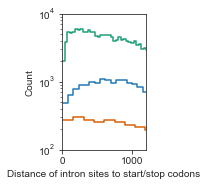

In [41]:
sns.set_style("ticks")
plt.figure(figsize=(1.5,2.5))
sns.histplot(x='evolved_ipos', data=dt[dt.history=='gain'],
             color='#d95f02', fill=False, element="step", legend=True)
sns.histplot(x='evolved_ipos', data=dt[dt.history=='loss'],
             color='#1f77b4', fill=False, element="step", legend=True)
sns.histplot(x='evolved_ipos', data=dt[dt.history=='present'], 
             color='#1b9e77', fill=False, element="step", legend=True)
plt.yscale('log')
plt.xlim(0, 1200)
plt.ylim(100, 10000)
plt.xlabel('Distance of intron sites to start/stop codons')
plt.savefig('wrt_start.pdf')

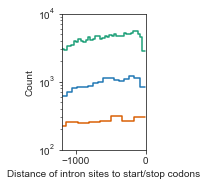

In [42]:
sns.set_style("ticks")
plt.figure(figsize=(1.5,2.5))
sns.histplot(x='dist_wrt_stop', data=dt[dt.history=='gain'], 
             color='#d95f02', fill=False, element="step", alpha=0.5)
sns.histplot(x='dist_wrt_stop', data=dt[dt.history=='loss'], 
             color='#1f77b4', fill=False, element="step", alpha=0.5)
sns.histplot(x='dist_wrt_stop', data=dt[dt.history=='present'], 
             color='#1b9e77', fill=False, element="step", legend=True)
plt.yscale('log')
plt.xlim(-1200, 0)
plt.ylim(100, 10000)
plt.xlabel('Distance of intron sites to start/stop codons')
plt.savefig('wrt_stop.pdf')